<a href="https://colab.research.google.com/github/jujuGthb/Apple_Stock_Price_Prediction_II/blob/main/appl_pred_XTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:


import os
project_dir = os.path.join('/content/drive/My Drive/Colab Notebooks')
model_path = os.path.join(project_dir, 'aapl_stock_prediction_informer.keras')


In [ ]:
!pip install --upgrade yfinance
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [4]:
import yfinance as yf
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
def download_data_with_retry(ticker, start, end, interval, max_retries=5, delay=5):
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=False)


            print("Download successful!")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print("All retry attempts failed.")
    return None

# Defining parameters
ticker = 'AAPL'
start_date = '2004-01-01'
end_date = '2024-01-01'
interval = '1d'

# Downloading data
data = download_data_with_retry(ticker, start_date, end_date, interval)


if data is not None:
    print(f"Number of records downloaded: {len(data)}")
else:
    print("Data download failed.")

[*********************100%***********************]  1 of 1 completed

Download successful!
Number of records downloaded: 5033


In [ ]:
data.head(5)

In [6]:
# Checking  MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [ ]:
data.columns

In [7]:
data = data.round(2)
data.head(5)

,adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200


## Adding Columns

#### Feature Engineering

In [8]:

# Time-Based Features
data['DayofWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# Lagged Features (previous day's values)
data['Close_Lag1'] = data['Close'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)


data['Price Change %'] = data['Close'].pct_change() * 100
data['Volatility_20'] = data['Close'].rolling(window=20).std()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Interaction Features
data['Close_Volatility'] = data['Close'] * data['Volatility_20']



if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

    data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume','Price Change %', 'Volatility_20', 'SMA_50', 'EMA_50']



data = data.round(2)




In [9]:
data.to_csv('AAPL_stock_data.csv')

## Data Processing

In [ ]:
import pandas as pd

data = pd.read_csv('AAPL_stock_data.csv', header=0, parse_dates=['Date'], index_col='Date')

data = data.bfill()



print(f"Data Info:\n {data.info}")
print(f"Sum of null data:\n {data.isnull().sum()}")






In [11]:
data.tail(5)

,adj Close,Close,High,Low,Open,Volume,DayofWeek,Month,Quarter,Close_Lag1,Volume_Lag1,Price Change %,Volatility_20,SMA_50,EMA_50,Close_Volatility
Date,,,,,,,,,,,,,,,,
2023-12-22,192.66,193.60,195.41,192.97,195.18,37122800,4,12,4,194.68,46482500.0,-0.55,2.91,185.40,188.23,563.57
2023-12-26,192.11,193.05,193.89,192.83,193.61,28919300,1,12,4,193.60,37122800.0,-0.28,2.77,185.68,188.42,534.80
2023-12-27,192.21,193.15,193.50,191.09,192.49,48087700,2,12,4,193.05,28919300.0,0.05,2.66,185.97,188.60,513.18
2023-12-28,192.64,193.58,194.66,193.17,194.14,34049900,3,12,4,193.15,48087700.0,0.22,2.43,186.30,188.80,470.50
2023-12-29,191.59,192.53,194.40,191.73,193.90,42628800,4,12,4,193.58,34049900.0,-0.54,2.26,186.63,188.94,434.43


## Model Building

In [ ]:
pip install torch pandas numpy matplotlib scikit-learn

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

##### Normalize dataset

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

# Using the last 60 days' data to predict the next day
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(data)):
    X.append(data['Close'].iloc[i-sequence_length:i].values)
    y.append(data['Close'].iloc[i])

X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


#### Convert to torch tensors

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)




##### Model Definition

In [16]:
class XTransformer(nn.Module):
    def __init__(self, input_size=1, hidden_dim=64, num_heads=8, num_layers=4, output_size=1):
        super(XTransformer, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.output_size = output_size


        self.input_projection = nn.Linear(input_size, hidden_dim)

        # The Transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim,
            nhead=self.num_heads,
            dim_feedforward=256
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers)

        # Output layer
        self.fc = nn.Linear(self.hidden_dim, self.output_size)

    def forward(self, x):

        x = self.input_projection(x)

        # Convert the input to shape (seq_len, batch_size, input_dim)
        x = x.permute(1, 0, 2)

        x = self.encoder(x)

        # Last time-step for prediction
        x = x[-1, :, :]

        # Output layer
        x = self.fc(x)

        return x

#### Model Training

In [54]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation
train_data, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


epochs = 50
learning_rate = 0.001

# Initialize the Model, Optimizer, and Loss Function
model = XTransformer(input_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Mean Squared Error Loss


train_losses = []
val_losses = []


for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_mae = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        output = model(X_batch)

        # Calculate loss (MSE)
        loss = criterion(output, y_batch.view(-1, 1))

        # Calculate MAE
        mae = torch.mean(torch.abs(output - y_batch.view(-1, 1)))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mae += mae.item()

    # Store training loss for this epoch
    train_losses.append(epoch_loss / len(train_loader))

    # Compute the validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:  # Assuming val_loader is defined
            output = model(X_batch)
            loss = criterion(output, y_batch.view(-1, 1))
            epoch_val_loss += loss.item()

    # Store the validation loss for this epoch
    val_losses.append(epoch_val_loss / len(val_loader))


    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, MAE: {epoch_mae/len(train_loader):.4f}, Validation Loss: {val_losses[-1]:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.2296, MAE: 0.3759, Validation Loss: 0.0581
Epoch 2/50, Loss: 0.0254, MAE: 0.1322, Validation Loss: 0.0061
Epoch 3/50, Loss: 0.0141, MAE: 0.0914, Validation Loss: 0.0114
Epoch 4/50, Loss: 0.0117, MAE: 0.0863, Validation Loss: 0.0053
Epoch 5/50, Loss: 0.0093, MAE: 0.0778, Validation Loss: 0.0056
Epoch 6/50, Loss: 0.0096, MAE: 0.0789, Validation Loss: 0.0049
Epoch 7/50, Loss: 0.0083, MAE: 0.0721, Validation Loss: 0.0048
Epoch 8/50, Loss: 0.0080, MAE: 0.0709, Validation Loss: 0.0044
Epoch 9/50, Loss: 0.0064, MAE: 0.0629, Validation Loss: 0.0028
Epoch 10/50, Loss: 0.0048, MAE: 0.0557, Validation Loss: 0.0009
Epoch 11/50, Loss: 0.0030, MAE: 0.0439, Validation Loss: 0.0001
Epoch 12/50, Loss: 0.0024, MAE: 0.0380, Validation Loss: 0.0008
Epoch 13/50, Loss: 0.0024, MAE: 0.0392, Validation Loss: 0.0001
Epoch 14/50, Loss: 0.0023, MAE: 0.0373, Validation Loss: 0.0002
Epoch 15/50, Loss: 0.0019, MAE: 0.0355, Validation Loss: 0.0001
Epoch 16/50, Loss: 0.0016, MAE: 0.0318, Validatio

#### Validation and Training Loss

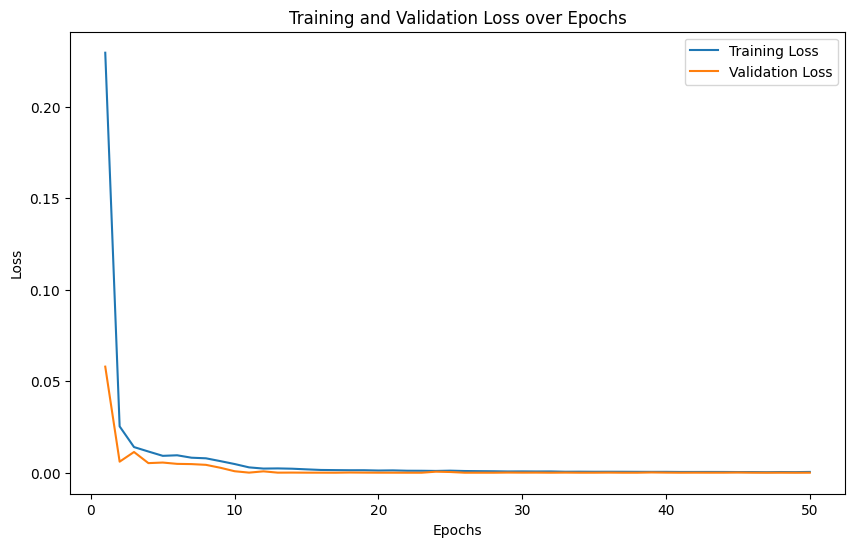

In [55]:

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')

plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

plt.legend()

plt.show()


### Evaluate the Model

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Set model to evaluation mode
model.eval()

y_pred = []
y_true = []


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)

        y_pred.append(output)
        y_true.append(y_batch)

# Concatenate the predictions and actual values from all batches
y_pred = torch.cat(y_pred, dim=0).numpy()
y_true = torch.cat(y_true, dim=0).numpy()


# the required metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)


print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 0.0038
MAE: 0.0496
MAPE: 30.9835%
RMSE: 0.0613
R-squared: 0.8634


#### Save the model

In [57]:

torch.save(model, model_path)


In [ ]:

model = torch.load(model_path)

model.eval()


#### True and Predicted Prices

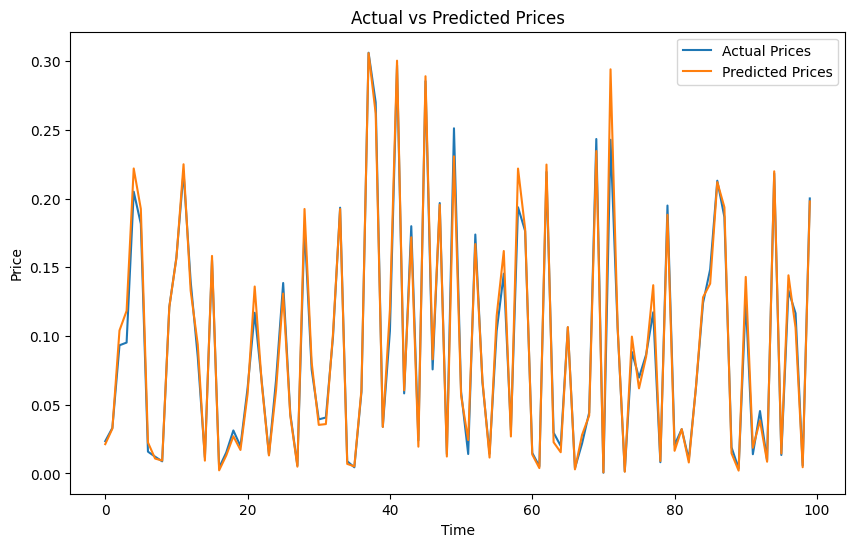

In [59]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()


y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:

        predictions = model(X_batch)

        # Append the actual and predicted values to the lists
        y_true.append(y_batch.numpy())
        y_pred.append(predictions.numpy())

# Convert the lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)



plt.figure(figsize=(10, 6))
plt.plot(y_true[:100], label='Actual Prices')
plt.plot(y_pred[:100], label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
